In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
import datetime
import torch
import torch.nn as nn
import torchvision
import torch.utils.data

In [2]:
#read data
data_set_path = "./6 Speech Recognition"
x_sound = np.load("{}/XSound.npy".format(data_set_path))#(15737,62,65,1)
y_sound = np.load("{}/YSound.npy".format(data_set_path))#(15737)
label_dict = {"Yes":3,"No":1,"Stop":2,"Go":0}

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

In [3]:
cnn_dataset = []
min_max = None
for i in range(y_sound.shape[0]):
    label = y_sound[i]
    data = np.transpose(x_sound[i,:,:,:],(2, 1, 0))
    if min_max is None:
        min_max = [np.min(data),np.max(data)]
    else:
        min_max = [min(np.min(data),min_max[0]),max(np.max(data),min_max[1])]
    data = data/data.max()*255#normalize data
    cnn_dataset.append([data,label])
print("min:{} max:{}".format(min_max[0],min_max[1]))
cnn_train_validation_set, cnn_test_set = train_test_split(cnn_dataset, test_size=0.2, random_state=69)
cnn_train_set, cnn_validation_set = train_test_split(cnn_train_validation_set, test_size=0.25, random_state=69)
print("train:{} validation:{} test:{}".format(len(cnn_train_set),len(cnn_validation_set),len(cnn_test_set)))

min:0.0 max:127.0
train:9441 validation:3148 test:3148


In [4]:
knn_datasets = [[[],[]],[[],[]],[[],[]]]
cnn_datasets = [cnn_train_set,cnn_validation_set,cnn_test_set]
for i,knn_dataset in enumerate(knn_datasets):
    dataset = cnn_datasets[i]
    for data,label in dataset:
        data = np.reshape(data,(1,data.shape[0]*data.shape[1]*data.shape[2]))
        knn_dataset[0].append(data)
        knn_dataset[1].append(label)
    knn_dataset[0] = np.concatenate(knn_dataset[0],axis=0)
    knn_dataset[1] = np.array(knn_dataset[1])
[knn_train_set,knn_validation_set,knn_test_set] = knn_datasets

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

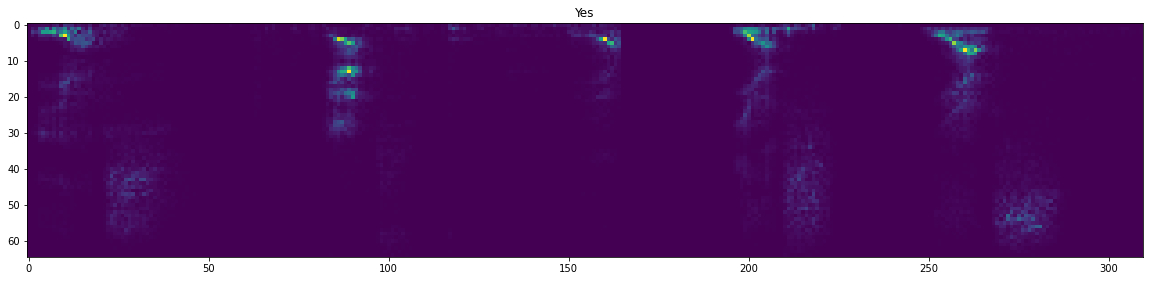

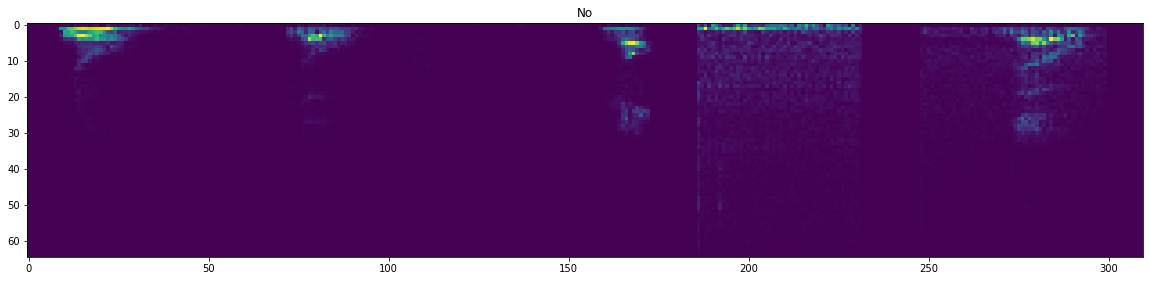

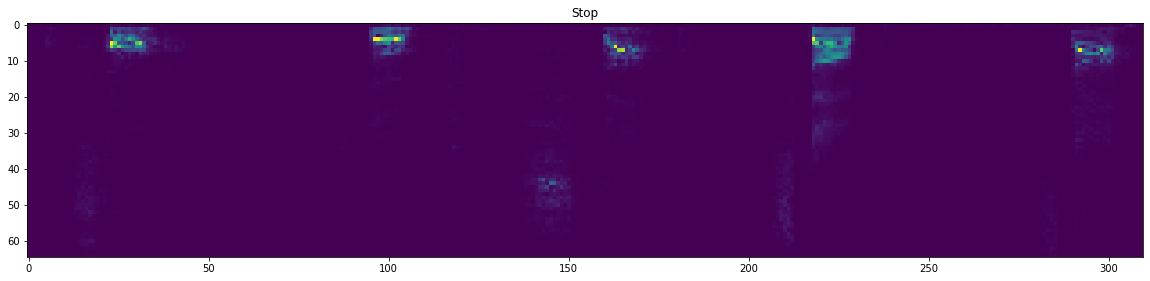

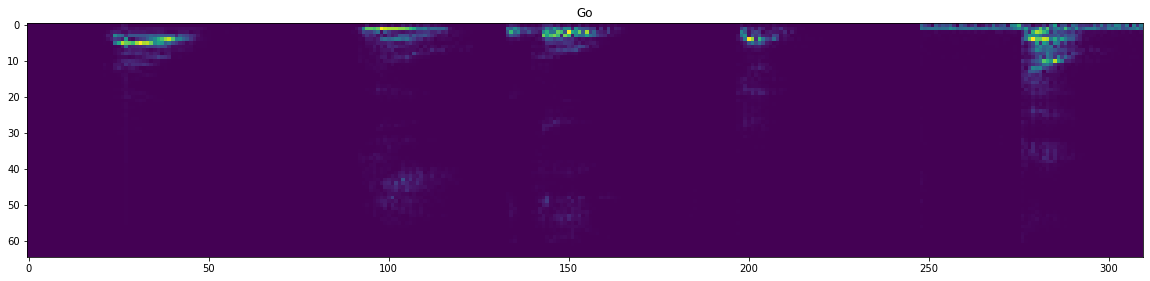

In [5]:
num = 5
for label in label_dict.keys():
    n = 0
    id = label_dict[label]
    spectrogram = None
    b = None
    for data,label_id in cnn_train_set:
        if id == label_id and n<num:
            n+=1
            if spectrogram is None:
                spectrogram = data
            else:
                spectrogram = np.dstack([spectrogram,data])
            if n == num:
                break
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.merge(spectrogram))
    plt.title(label)
    plt.show()

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

In [6]:
#cnn_config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#cnn_model_create
cnn_model = torchvision.models.resnet18(pretrained=False)
cnn_model.conv1 = nn.Conv2d(1, cnn_model.conv1.out_channels, kernel_size=(1,1), stride=(1,1), padding=0, bias=False)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 4)
cnn_model.to(device)
print("[device]: {}".format(device))

[device]: cpu


In [7]:
def test_cnn_model(data_set,max_num=-1,ckpt=None):
    if ckpt is not None:
        load_ckpt = torch.load(ckpt, map_location=torch.device(device))
        cnn_model.load_state_dict(load_ckpt, strict=True)
    if max_num==-1:
        max_num = len(data_set)

    test_data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=1, shuffle=False)
    torch.manual_seed(69)

    target_list = []
    out_list = []
    for i, (data,label) in enumerate(test_data_loader):
        label = np.sum(label.detach().cpu().numpy())
        out = cnn_model(data.to(device))
        probability_list = out.detach().cpu().numpy()
        out_id = np.argmax(probability_list)
        target_list.append(label)
        out_list.append(out_id)
        if i+1>=max_num:
            break
    target_list = np.array(target_list)
    out_list = np.array(out_list)
    tpr = np.sum(np.where((target_list==out_list),1,0))/len(target_list)
    return tpr,[target_list,out_list]

In [8]:
def train_cnn_model(data_set,total_loss_list=None,ckpt=None):
    epoch_num = 5
    lr = 1e-3
    batch_size = 4

    if ckpt is not None:
        cnn_model.load_state_dict(ckpt, strict=True)

    if total_loss_list is None:
        total_loss_list = []

    train_data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=1, shuffle=True)
    torch.manual_seed(69)

    #loss
    cnn_loss = nn.CrossEntropyLoss()
    #optimizer
    optimizer = torch.optim.Adam(cnn_model.parameters(),lr=lr)
    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", cooldown=0, patience=2)

    print("[{}] training start".format(datetime.datetime.now()))
    for epoch in range(epoch_num):
        batch_loss = None
        batch_num = 0
        total_loss = 0.0
        part_total_loss = 0.0
        min_loss = None
        max_loss = None
        n_p = 0
        min_avg_loss = None
        loss_list = []
        for i, (data,label) in enumerate(train_data_loader):
            out = cnn_model(data.to(device))
            loss = cnn_loss(out,label.long())

            if batch_loss==None:
                batch_loss = loss/batch_size
            else:
                batch_loss = batch_loss+loss/batch_size
            batch_num += 1

            if batch_num == batch_size or i+1 == len(cnn_train_set):
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                batch_loss = None
                batch_num = 0

            #statistical data
            loss_list.append(loss.item())
            if min_loss is not None:
                min_loss = min(min_loss, loss.item())
            else:
                min_loss = loss.item()
            if max_loss is not None:
                max_loss = max(max_loss, loss.item())
            else:
                max_loss = loss.item()

            total_loss = total_loss + loss.item()
            part_total_loss = part_total_loss + loss.item()

            n = i + 1
            n_p += 1
            print_p = math.ceil(len(train_data_loader) / 10)
            if int(n / print_p) * print_p == n:
                lr = optimizer.param_groups[0]['lr']
                min_loss_str = "{:.6f}".format(min_loss)
                max_loss_str = "{:.6f}".format(max_loss)
                part_avg_loss_str = "{:.6f}".format(part_total_loss / n_p)
                scheduler.step(part_total_loss / n_p)
                tpr,_ = test_cnn_model(cnn_validation_set,500)
                print("[{}] lr:{:.3e}, {}/{}, [min_loss]:{}, [max_loss]:{}, [part_avg_loss]:{} [TPR]:{:.6f}".format(datetime.datetime.now(), lr, n, len(train_data_loader), min_loss_str, max_loss_str,part_avg_loss_str,tpr))
                part_total_loss = 0.0
                n_p = 0
        data_num = len(train_data_loader)
        n_e = 0
        avg_loss = total_loss / data_num
        total_loss = 0.0
        if min_avg_loss is not None:
            min_avg_loss = min(min_avg_loss, avg_loss)
        else:
            min_avg_loss = avg_loss
        avg_loss_str = "{:.6f}".format(avg_loss)
        min_loss_str = "{:.6f}".format(min_loss)
        max_loss_str = "{:.6f}".format(max_loss)
        min_avg_loss_str = "{:.6f}".format(min_avg_loss)
        lr = optimizer.param_groups[0]['lr']
        tpr,_ = test_cnn_model(cnn_validation_set)
        info = "[Epoch]:{}, [data_num]:{}, [lr]:{:.3e}, [avg_loss]:{}, [min_loss]:{}, [max_loss]:{}, [min_avg_loss]:{} [TPR]:{:.6f}".format(epoch, data_num, lr, avg_loss_str, min_loss_str, max_loss_str,min_avg_loss_str,tpr)
        print(info)
        total_loss_list+=loss_list
        torch.save(cnn_model.state_dict(), "Assignment6_cnn.pth")
        #plt.plot(range(len(loss_list)),loss_list)
        #plt.title("loss of epoch_{}".format(epoch))
        #plt.show()
    return total_loss_list

In [9]:
#cnn_model
loss_list = train_cnn_model(cnn_train_set)

[2022-11-14 23:14:10.885360] training start
[2022-11-14 23:16:02.309486] lr:1.000e-03, 945/9441, [min_loss]:0.016554, [max_loss]:4.102254, [part_avg_loss]:1.051228 [TPR]:0.636000
[2022-11-14 23:17:59.342317] lr:1.000e-03, 1890/9441, [min_loss]:0.005416, [max_loss]:5.177523, [part_avg_loss]:0.576748 [TPR]:0.810000
[2022-11-14 23:20:05.966988] lr:1.000e-03, 2835/9441, [min_loss]:0.002253, [max_loss]:5.205127, [part_avg_loss]:0.457005 [TPR]:0.860000
[2022-11-14 23:22:07.835000] lr:1.000e-03, 3780/9441, [min_loss]:0.000984, [max_loss]:5.205127, [part_avg_loss]:0.357473 [TPR]:0.852000
[2022-11-14 23:24:16.894551] lr:1.000e-03, 4725/9441, [min_loss]:0.000509, [max_loss]:5.205127, [part_avg_loss]:0.313431 [TPR]:0.894000
[2022-11-14 23:26:28.277919] lr:1.000e-03, 5670/9441, [min_loss]:0.000509, [max_loss]:5.205127, [part_avg_loss]:0.311451 [TPR]:0.898000
[2022-11-14 23:28:34.976778] lr:1.000e-03, 6615/9441, [min_loss]:0.000182, [max_loss]:6.103052, [part_avg_loss]:0.300706 [TPR]:0.906000
[2022

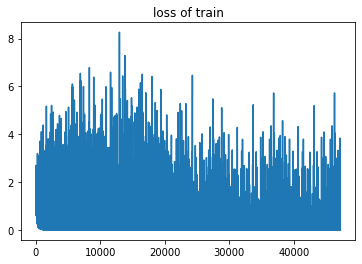

In [10]:
plt.plot(range(len(loss_list)),loss_list)
plt.title("loss of train")
plt.show()

In [11]:
tpr,[target_list,out_list] = test_cnn_model(cnn_test_set)
print("total_TPR:{:.6f}".format(tpr))

total_TPR:0.959657


In [12]:
def train_knn_model(data_set):
    knn_model.fit(data_set[0],data_set[1])

In [13]:
def test_knn_model(data_set,max_num=-1,n_neighbors=0):
    if n_neighbors>=0:
        knn_model.n_neighbors = n_neighbors
    if max_num==-1:
        max_num = data_set[0].shape[0]
    target_list = data_set[1][0:max_num]
    choose_data = data_set[0][0:max_num,:]
    out_list = knn_model.predict(choose_data)
    tpr = np.sum(np.where((target_list==out_list),1,0))/max_num
    return tpr,[target_list,out_list]

[knn]:validation [best_n]:7 [TPR]:0.754447


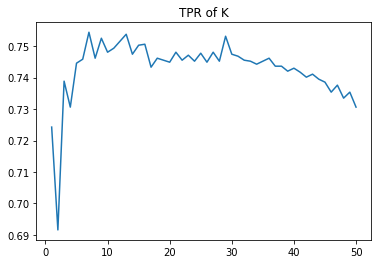

In [14]:
#knn_model
knn_model = knn(n_jobs=-1)
train_knn_model(knn_train_set)
start_k = 1
max_k = 50
knn_best_k = 0
knn_best_validation_tpr = 0
tpr_list = []
for k in range(start_k,max_k+1):
    tpr,[target_list,out_list] = test_knn_model(knn_validation_set,n_neighbors=k)
    tpr_list.append(tpr)
    if tpr>=knn_best_validation_tpr:
        knn_best_validation_tpr = tpr
        knn_best_k = k
print("[knn]:validation [best_n]:{} [TPR]:{:.6f}".format(knn_best_k,knn_best_validation_tpr))
plt.plot(range(start_k,start_k+len(tpr_list)),tpr_list)
plt.title("TPR of K")
plt.show()

 I think the convolution neural network is suitable for this kind of problem, because the data is a kind of spectrogram, it can be viewed as a type of image. The CNN can extract features from an image and reduce the effect of location information by fourier transform to improve the TPR(recall) of the model.

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

In [15]:
def calculate_metrics(target_list,out_list):
    confusion_matrix = np.zeros([len(label_dict),len(label_dict)])
    for l_i,label_name in enumerate(label_dict.keys()):
        label = label_dict[label_name]
        tp = np.sum(np.where((target_list==label) & (out_list==label),1,0))
        for l_fp_i,label_fp_name in enumerate(label_dict.keys()):
            label_fp = label_dict[label_fp_name]
            if label!= label_fp:
                fp = np.sum(np.where((target_list==label_fp) & (out_list==label),1,0))
                confusion_matrix[l_i,l_fp_i] = fp
            else:
                confusion_matrix[l_i,l_fp_i] = tp
    aprf_list = []
    tp_model = 0
    fp_model = 0
    fn_model = 0
    tn_model = 0
    for l_i,label_name in enumerate(label_dict.keys()):
        tp = confusion_matrix[l_i,l_i]
        fp = np.sum(confusion_matrix[l_i,:]) - tp
        fn = np.sum(confusion_matrix[:,l_i]) - tp
        tn = np.sum(confusion_matrix) - tp - fp - fn
        tp_model += tp
        fp_model += fp
        fn_model += fn
        tn_model += tn
        accuracy = (tp+tn)/(tp+fp+fn+tn)
        precision = tp / (tp+fp)
        recall =tp / (tp+fn)
        f_score = 2*precision * recall / (precision + recall)
        aprf_list.append([label_name,accuracy,precision,recall,f_score])
    accuracy_model = (tp_model+tn_model)/(tp_model+fp_model+fn_model+tn_model)
    precision_model = tp_model / (tp_model+fp_model)
    recall_model =tp_model / (tp_model+fn_model)
    f_score_model = 2*precision_model * recall_model / (precision_model + recall_model)
    return [confusion_matrix,accuracy_model,precision_model,recall_model,f_score_model,aprf_list]

In [16]:
#test cnn model
cnn_tpr,[cnn_target_list,cnn_out_list] = test_cnn_model(cnn_test_set,ckpt="Assignment6_cnn.pth")
cnn_result = calculate_metrics(cnn_target_list,cnn_out_list)
print("[cnn] [accuracy]:{:.2%} [precision]:{:.2%} [recall]:{:.2%} [f_score]:{}".format(cnn_result[1],cnn_result[2],cnn_result[3],cnn_result[4]))
for label_name,accuracy,precision,recall,f_score in cnn_result[5]:
    print("[{}] [accuracy]:{:.2%} [precision]:{:.2%} [recall]:{:.2%} [f_score]:{}".format(label_name,accuracy,precision,recall,f_score))
#test knn model
knn_tpr,[knn_target_list,knn_out_list] = test_knn_model(knn_test_set,n_neighbors=knn_best_k)
knn_result = calculate_metrics(knn_target_list,knn_out_list)
print("\n[knn] [accuracy]:{:.2%} [precision]:{:.2%} [recall]:{:.2%} [f_score]:{}".format(knn_result[1],knn_result[2],knn_result[3],knn_result[4]))
for label_name,accuracy,precision,recall,f_score in knn_result[5]:
    print("[{}] [accuracy]:{:.2%} [precision]:{:.2%} [recall]:{:.2%} [f_score]:{}".format(label_name,accuracy,precision,recall,f_score))

[cnn] [accuracy]:97.98% [precision]:95.97% [recall]:95.97% [f_score]:0.9596569250317663
[Yes] [accuracy]:99.14% [precision]:98.60% [recall]:97.98% [f_score]:0.9829222011385199
[No] [accuracy]:97.01% [precision]:94.06% [recall]:94.29% [f_score]:0.9417596034696407
[Stop] [accuracy]:98.92% [precision]:97.27% [recall]:98.29% [f_score]:0.9778067885117494
[Go] [accuracy]:96.86% [precision]:93.99% [recall]:93.39% [f_score]:0.9369024856596558

[knn] [accuracy]:87.25% [precision]:74.49% [recall]:74.49% [f_score]:0.7449174078780179
[Yes] [accuracy]:91.42% [precision]:85.29% [recall]:79.70% [f_score]:0.8239895697522817
[No] [accuracy]:84.66% [precision]:72.97% [recall]:63.65% [f_score]:0.679920477137177
[Stop] [accuracy]:90.63% [precision]:79.52% [recall]:82.55% [f_score]:0.8100450740502254
[Go] [accuracy]:82.27% [precision]:62.54% [recall]:72.55% [f_score]:0.6717647058823529


The TPR(recall) of the CNN model has 20% higher than the KNN model, and for each type of label, the CNN model can improve the recall rate by 10% to 30%.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

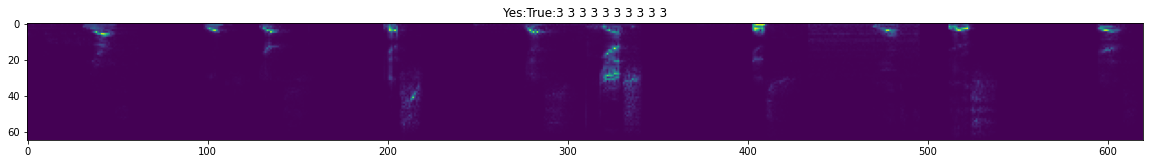

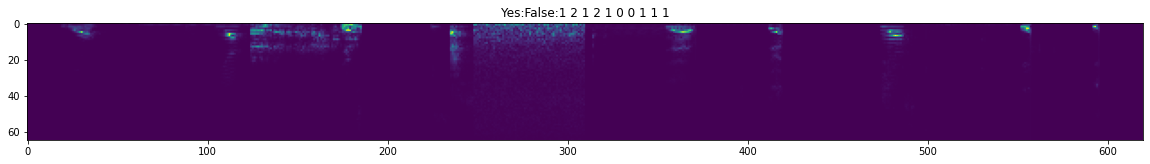

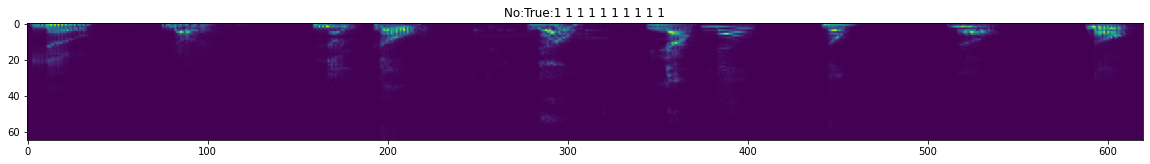

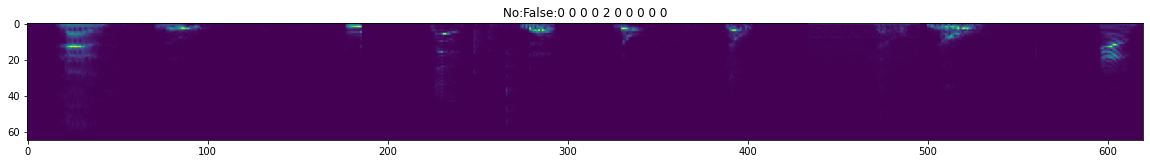

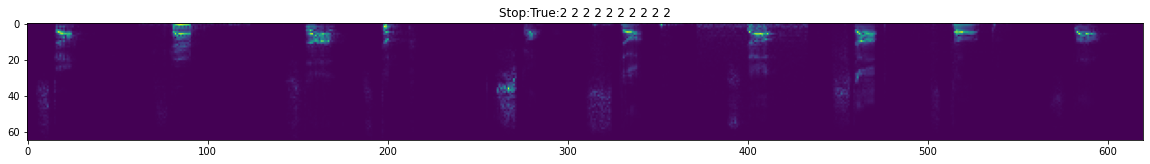

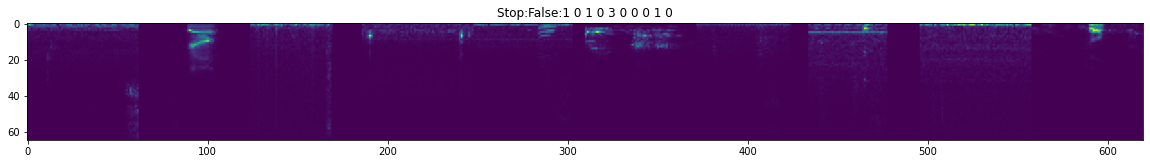

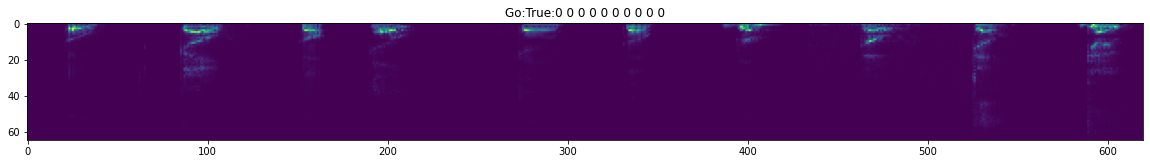

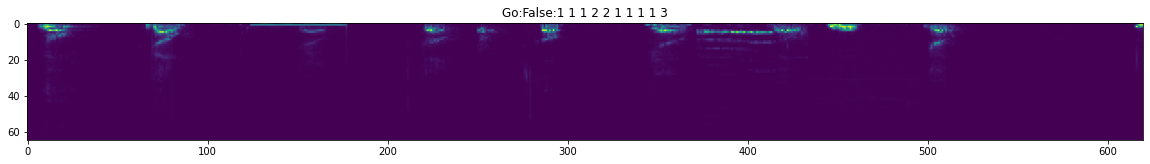

In [17]:
true_list = np.where(cnn_target_list==cnn_out_list,1,0)
max_num = 10
id_dict = {}
for key in label_dict.keys():
    id_dict[label_dict[key]] = key
print_dict = {"Yes":[[],[]],"No":[[],[]],"Stop":[[],[]],"Go":[[],[]]}
max_lists = {}
for i,target in enumerate(cnn_target_list):
    r = true_list[i]
    add_list = []
    if r == 1:
        add_list = print_dict[id_dict[target]][0]
    else:
        add_list = print_dict[id_dict[target]][1]
    if len(add_list)<max_num:
        add_list.append([cnn_test_set[i][0],cnn_out_list[i]])
    else:
        max_lists["{} {}".format(target,r)] = 1
    if len(max_lists) == 8:
        break

for name in print_dict.keys():
    true_list,false_list = print_dict[name]
    true_show = None
    false_show = None
    true_out_show = ""
    for true_data,true_out in true_list:
        if true_show is None:
            true_show = true_data
            true_out_show+="{}".format(true_out)
        else:
            true_show = np.dstack([true_show,true_data])
            true_out_show+=" {}".format(true_out)

    false_out_show = ""
    for false_data,false_out in false_list:
        if false_show is None:
            false_show = false_data
            false_out_show+="{}".format(false_out)
        else:
            false_show = np.dstack([false_show,false_data])
            false_out_show+=" {}".format(false_out)

    plt.figure(figsize=(20,20))
    plt.imshow(cv2.merge(true_show))
    plt.title("{}:True:{}".format(name,true_out_show))
    plt.show()
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.merge(false_show))
    plt.title("{}:False:{}".format(name,false_out_show))
    plt.show()

Most misclassified data are incomplete or have noise and don't have a clear feature for classification. These misclassified examples shouldn't as a surprise.